In [1]:
%reset

In [6]:
import tensorflow as tf
import numpy as np
import sionna as sn
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt

In [38]:
class ModifiedRappModel(tf.keras.layers.Layer):
    """TensorFlow implementation of Modified Rapp Power Amplifier Model"""

    def __init__(self, vsat=0.5, p=1.75, g_r=1.0, q1=1.4, q2=1.4,
                 alpha=-490, beta=0.17):
        super().__init__()

        self.vsat = vsat
        self.p = p
        self.g_r = g_r
        self.q1 = q1
        self.q2 = q2
        self.alpha = alpha
        self.beta = beta

    @tf.function
    def amplify(self, vin):
        """
        Apply Modified Rapp model amplification
        vin: complex tensor (tf.complex64 or tf.complex128)
        """

        vin = tf.cast(vin, tf.complex64)

        abs_v = tf.abs(vin)

        # -----------------------------
        # AM / AM conversion
        # -----------------------------
        vout_m = (
            self.g_r * abs_v /
            tf.pow(
                1.0 + tf.pow(self.g_r * abs_v / self.vsat, 2.0 * self.p),
                1.0 / (2.0 * self.p)
            )
        )

        # -----------------------------
        # AM / PM conversion
        # -----------------------------
        abs_v_pm = tf.abs(vin / 10.0)

        vout_p = (
            self.alpha * tf.pow(abs_v_pm, self.q1) /
            (1.0 + tf.pow(abs_v_pm, self.q2) / self.beta)
        )

        # -----------------------------
        # Combine AM/AM and AM/PM
        # -----------------------------
        phase = tf.math.angle(vin)
        phase_out = vout_p * (np.pi / 180.0) + phase

        vout = tf.cast(vout_m, tf.complex64) * tf.exp(
            tf.complex(tf.zeros_like(phase_out), phase_out)
        )

        return vout


class PAModel(tf.keras.Model):
    def __init__(self, fs, f0, device='cpu'):
        super().__init__()
        self.fs = fs
        self.f0 = f0

        # PA variation parameters
        vsat_var = 0.1
        p_var = 0.1

        # Modified Rapp model parameters
        self.vsat = 0.5 + vsat_var
        self.p = 1.75 + p_var
        self.g_r = 1.0
        self.q1 = 1.4
        self.q2 = 1.4
        self.alpha = -490
        self.beta = 0.17

        # Modified Rapp model (TensorFlow version)
        self.rapp_model = ModifiedRappModel(
            vsat=self.vsat,
            p=self.p,
            g_r=self.g_r,
            q1=self.q1,
            q2=self.q2,
            alpha=self.alpha,
            beta=self.beta
        )

    # @tf.function
    def forward_differentiable(self, x):
        """
        Wiener-like differentiable PA model for training
        Structure: LTI Filter -> Rapp Nonlinearity -> LTI Filter
        """

        n_samples = tf.shape(x)[1]
        n_samples_f = tf.cast(n_samples, tf.float32)
        # tf.print('test')

        # Frequency grid
        f_vect = tf.linspace(
            -self.fs / 2.0,
            self.fs / 2.0 - self.fs / n_samples_f,
            n_samples
        ) + self.f0

        # Memory parameters
        alpha_pre  = 0.25
        alpha_post = 0.50

        k1_pre,  k2_pre  = 0.0, 0.50
        k1_post, k2_post = 0.0, 1.00

        # -----------------------
        # Pre-filter
        # -----------------------
        f_norm_pre = (f_vect - self.f0) / (self.fs / 2.0)
        mag_pre = tf.exp(-alpha_pre * tf.square(f_norm_pre))
        phase_pre = k1_pre * f_norm_pre + k2_pre * tf.square(f_norm_pre)
        h_pre = tf.cast(mag_pre, tf.complex64) * tf.exp(
            tf.complex(tf.zeros_like(phase_pre), phase_pre)
        )

        # -----------------------
        # Post-filter
        # -----------------------
        f_norm_post = (f_vect - self.f0) / (self.fs / 2.0)
        mag_post = tf.exp(-alpha_post * tf.square(f_norm_post))
        phase_post = k1_post * f_norm_post + k2_post * tf.square(f_norm_post)
        h_post = tf.cast(mag_post, tf.complex64) * tf.exp(
            tf.complex(tf.zeros_like(phase_post), phase_post)
        )

        # Normalize filters
        h_pre /= tf.complex(tf.sqrt(tf.reduce_mean(tf.abs(h_pre) ** 2)),0.0)
        h_post /= tf.complex(tf.sqrt(tf.reduce_mean(tf.abs(h_post) ** 2)),0.0)

        # -----------------------
        # FFT helpers
        # -----------------------
        def fft(x):
            return tf.signal.fftshift(
                tf.signal.fft(tf.signal.ifftshift(x))
            )

        def ifft(x):
            return tf.signal.fftshift(
                tf.signal.ifft(tf.signal.ifftshift(x))
            )


        # tf.print('h_post: ', h_post.numpy())

        # -----------------------
        # Pre-filtering
        # -----------------------
        x_freq = fft(x) / tf.cast(n_samples, tf.complex64)
        tf.print('h_pre: ', h_pre.shape)
        tf.print('x_freq: ', x_freq.shape)
        x_freq_pre = h_pre * x_freq
        x_pre = ifft(x_freq_pre) * tf.cast(n_samples, tf.complex64)

        # tf.print('x_freq: ', x_freq.numpy())

        # -----------------------
        # Nonlinearity (Rapp)
        # -----------------------
        x_nonlinear = 100.0 * self.rapp_model.amplify(x_pre / 10.0)

        # -----------------------
        # Post-filtering
        # -----------------------
        x_nl_freq = fft(x_nonlinear) / tf.cast(n_samples, tf.complex64)
        x_freq_post = h_post * x_nl_freq
        yout = ifft(x_freq_post) * tf.cast(n_samples, tf.complex64)

        return yout


In [39]:
ModOrder = 256                     # Modulation order (M-QAM)
Nblock = 4096                      # length of the sequence (4096 -> 4)
NoverSampling  = 5                 # Number of samples per symbol (i.e. Oversampling factor)
rrcrollof = 0.35                   # Root-raised cosine filter roll-off (pulse shaping)
Rsym = 100e6                       # Symbol rate

f0 = 10e9
Fs = 5e8

In [40]:

class Modulator(Layer):

    def __init__(self, constellation, **kwargs):
        super(Modulator,self).__init__(**kwargs)

        # Define the real and imaginary parts of the constellation as trainable variables
        self.constellation_real = tf.Variable(constellation.real, dtype=tf.float32, trainable=True)
        self.constellation_imag = tf.Variable(constellation.imag, dtype=tf.float32, trainable=True)

    def call(self, s):
        # Combine the real and imaginary parts into a complex-valued constellation
        constellation_combined = tf.complex(self.constellation_real, self.constellation_imag)

        # Expand the signal dimension to align for matrix multiplication
        s = tf.expand_dims(s, axis=-1)

        # Calculate the normalization constant
        normalization_constant = tf.sqrt(
            tf.reduce_mean(tf.abs(constellation_combined) ** 2)
        )

        normalization_constant = tf.complex(normalization_constant,0.0)

        # Normalize the constellation
        norm_constellation = tf.expand_dims(constellation_combined, axis=0)  # Add batch dimension
        norm_constellation = norm_constellation / normalization_constant
        norm_constellation = tf.expand_dims(norm_constellation, axis=0)  # Expand further for batch processing

        # print('norm_constellation:', norm_constellation.shape)

        # Compute the modulated signal
        x_real = tf.matmul(tf.math.real(norm_constellation), s)
        x_imag = tf.matmul(tf.math.imag(norm_constellation), s)
        x = tf.complex(x_real, x_imag)

        return tf.squeeze(x, axis=[-2, -1])


upsampler = sn.phy.signal.Upsampling(samples_per_symbol=NoverSampling)
tx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=rrcrollof,
                                                 samples_per_symbol=NoverSampling,
                                                 span_in_symbols=32)





In [41]:
Mod_log2 = np.sqrt(ModOrder)
real_values = np.arange(-(Mod_log2 - 1), Mod_log2, 2)  # Real part values
imag_values = np.arange(-(Mod_log2 - 1), Mod_log2, 2)  # Imaginary part values

constellation = np.array([(x + 1j * y) for x in real_values for y in imag_values])
modulator = Modulator(constellation)

In [49]:
batch_size = 10

In [64]:
symbol_index_seq = tf.random.uniform(shape=(batch_size,Nblock), minval=0, maxval=ModOrder, dtype=tf.int32)

s = tf.one_hot(symbol_index_seq, depth=ModOrder, dtype=tf.float32)

# Modulate the symbols
x_mod = modulator(s)
# x_mod = tf.expand_dims(x_mod, axis=-1)

x_up = upsampler(x_mod)
x_tx_filt = tx_filter(x_up)
x_tx_filt = x_tx_filt[:,80:20560] #Cropping out the transients

In [69]:
pin = 9

rms_x = tf.sqrt(tf.reduce_mean(tf.abs(x_tx_filt) ** 2))
Gain = tf.complex(tf.pow(10.0, 9 / 20.0) / rms_x,0.0)

xin = Gain * x_tx_filt

In [70]:
print((Gain * x_tx_filt).shape)
print(xin.shape)
xin.dtype
# xin_batch = tf.expand_dims(xin, axis= 0)

(10, 20480)
(10, 20480)


tf.complex64

In [71]:
PAMODEL = PAModel(Fs,f0)

In [72]:
xout = PAMODEL.forward_differentiable(xin)

h_pre:  TensorShape([20480])
x_freq:  TensorShape([10, 20480])


In [58]:
xout.shape

TensorShape([10, 20480])

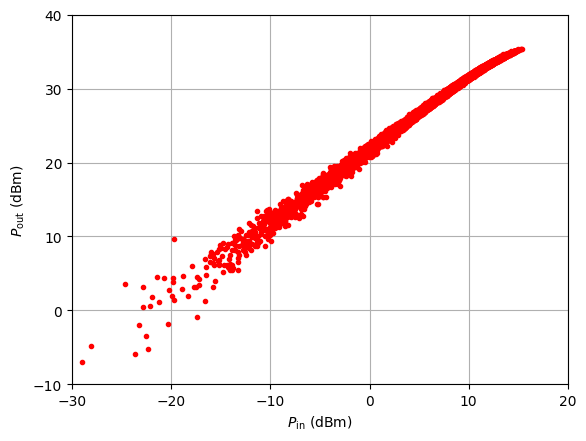

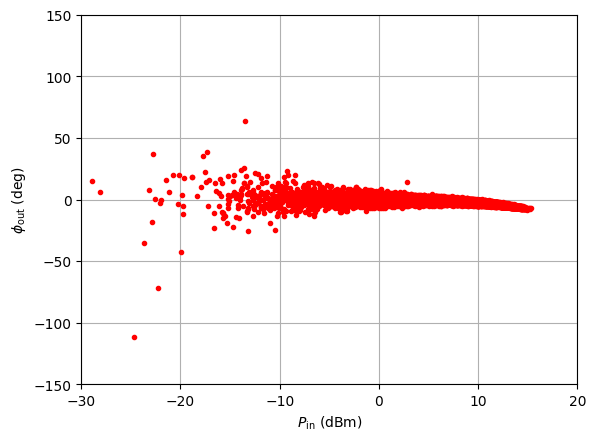

In [61]:

# If inputs are TensorFlow tensors, convert to NumPy
def to_numpy(z):
    return z.numpy() if hasattr(z, "numpy") else z

xin_np  = to_numpy(xin[5,:])
yout_np = to_numpy(xout[5,:])
x_np    = to_numpy(tf.squeeze(x_tx_filt[5,:]))

# -----------------------------
# AM/AM plot
# -----------------------------
plt.figure()
plt.plot(
    20 * np.log10(np.abs(xin_np)),
    20 * np.log10(np.abs(yout_np)),
    'r.',
)

plt.xlabel(r'$P_{\mathrm{in}}$ (dBm)')
plt.ylabel(r'$P_{\mathrm{out}}$ (dBm)')
plt.axis([-30, 20, -10, 40])
plt.grid(True)
plt.show()

# -----------------------------
# AM/PM plot
# -----------------------------
plt.figure()
plt.plot(
    20 * np.log10(np.abs(xin_np)),
    np.angle(yout_np / x_np) * 180 / np.pi,
    'r.',
)

plt.xlabel(r'$P_{\mathrm{in}}$ (dBm)')
plt.ylabel(r'$\phi_{\mathrm{out}}$ (deg)')
plt.axis([-30, 20, -150, 150])
plt.grid(True)
plt.show()


In [314]:

# xin = tf.convert_to_tensor(np.array([-1.0103 + 0.1123j,
#    1.4005 - 0.1556j,
#    2.9114 - 0.3235j,
#    2.4474 - 0.2719j,
#    0.2551 - 0.0283j,
#   -2.3152 + 0.3570j,
#   -3.0474 + 0.2003j,
#   -1.6242 - 0.1071j,
#    1.0965 - 0.3636j,
#    3.2925 - 0.3910j,
#    3.9484 - 0.4955j,
#    0.3828 + 0.6542j,
#   -3.6298 + 1.3864j,
#   -5.3794 + 1.1810j,
#   -3.5696 + 0.1435j,
#    2.1683 - 1.8216j,
#    2.5791 - 0.4418j,
#    1.1675 + 1.3158j,
#   -1.2216 + 2.2765j,
#   -3.0058 + 1.7524j]),dtype=tf.complex64)
#
# print(xin.dtype)
# # xin = tf.expand_dims(xin, axis=0)
# print(tf.signal.ifftshift(xin))
# print(tf.signal.fft(xin))
#
# print(np.fft.fft(xin.numpy()))

In [240]:
import skrf as rf

In [295]:
class PAModel_matlab(tf.Module):
    def __init__(self, Fs, f0, dtype=tf.complex64):
        super().__init__()

        self.Fs = Fs
        self.f0 = f0
        self.dtype = dtype

        # --------------------------
        # Load S-parameters ONCE
        # --------------------------
        net = rf.Network('HMC451LC3.s2p')
        self.s21 = net.s[:, 1, 0]        # complex numpy
        self.f_orig = net.f              # Hz

        # Modified Rapp PA
        # PA variation parameters
        # vsat_var = 0.1
        # p_var = 0.1
        # Modified Rapp model parameters
        self.vsat = 0.5# + vsat_var
        self.p = 1.75# + p_var
        self.g_r = 1.0
        self.q1 = 1.4
        self.q2 = 1.4
        self.alpha = -490
        self.beta = 0.17

        # Modified Rapp model (TensorFlow version)
        self.rapp_model = ModifiedRappModel(
            vsat=self.vsat,
            p=self.p,
            g_r=self.g_r,
            q1=self.q1,
            q2=self.q2,
            alpha=self.alpha,
            beta=self.beta
        )

    def _build_filter(self, Nx):
        """
        Create frequency-domain filter H(f) interpolated to FFT grid
        """
        fvect = tf.linspace(
            -self.Fs / 2.0,
             self.Fs / 2.0,
             Nx
        ) + self.f0

        # Interpolate real & imag separately (NumPy)
        H_real = np.interp(fvect.numpy(), self.f_orig, self.s21.real)
        H_imag = np.interp(fvect.numpy(), self.f_orig, self.s21.imag)

        Hfilt = tf.constant(H_real + 1j * H_imag, dtype=self.dtype)

        # Normalize mean power
        mean_gain = tf.sqrt(tf.reduce_mean(tf.abs(Hfilt)**2))
        return Hfilt / tf.complex(mean_gain,0.0)

    # @tf.function
    def __call__(self, x):
        """
        x: complex TF tensor (N,)
        """
        Nx = tf.shape(x)[0]
        Nx_c = tf.cast(Nx, self.dtype)

        # Build filter (depends on Nx)
        Hfilt = self._build_filter(Nx)

        # -----------------------
        # FFT helpers
        # -----------------------
        def fft(x):
            return tf.signal.fftshift(
                tf.signal.fft(tf.signal.ifftshift(x))
            )

        def ifft(x):
            return tf.signal.fftshift(
                tf.signal.ifft(tf.signal.ifftshift(x))
            )

        # FFT → filter → IFFT (MATLAB-consistent scaling)
        x_freq = Hfilt * fft(x
        ) / Nx_c

        x_filt = ifft(x_freq
        ) * Nx_c

        # tf.print('x_filt: ',x_filt.numpy())

        # Apply PA nonlinearity
        yout = 100.0 * self.rapp_model.amplify(x_filt / 10.0)

        return yout



In [306]:
PAModel_matlab_obj = PAModel_matlab(Fs, f0)

In [307]:
xout = PAModel_matlab_obj(xin)

In [311]:
print(tf.abs(xout[0,4000:4000+20])/10)
print(tf.abs(xin[0,4000:4000+20]))

tf.Tensor(
[1.7362105 2.0822217 2.162813  2.06411   1.9760596 2.0906262 2.4710803
 2.9991136 3.446383  3.6397088 3.4806106 2.8279378 1.7920555 1.6589149
 2.5415564 3.0586464 3.0507858 2.8788977 3.0881503 3.4796906], shape=(20,), dtype=float32)
tf.Tensor(
[1.7486475 2.1108105 2.196881  2.0915709 1.9985329 2.1197503 2.5344892
 3.159996  3.7734106 4.079381  3.825318  2.9486163 1.8064238 1.6690232
 2.6139617 3.2360046 3.2258875 3.0105212 3.274209  3.8239112], shape=(20,), dtype=float32)


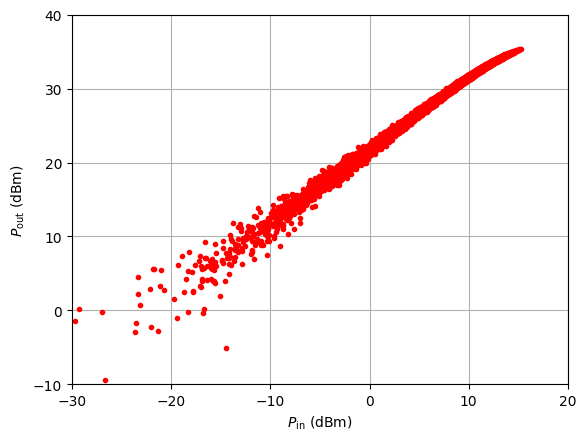

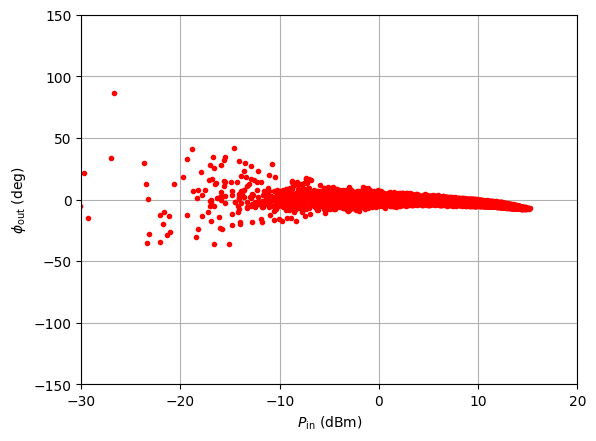

In [323]:
# If inputs are TensorFlow tensors, convert to NumPy
def to_numpy(z):
    return z.numpy() if hasattr(z, "numpy") else z

xin_np  = to_numpy(xin)
yout_np = to_numpy(xout)
x_np    = to_numpy(tf.squeeze(x_tx_filt))

# -----------------------------
# AM/AM plot
# -----------------------------
plt.figure()
plt.plot(
    20 * np.log10(np.abs(xin_np)),
    20 * np.log10(np.abs(yout_np)),
    'r.',
)

plt.xlabel(r'$P_{\mathrm{in}}$ (dBm)')
plt.ylabel(r'$P_{\mathrm{out}}$ (dBm)')
plt.axis([-30, 20, -10, 40])
plt.grid(True)
plt.show()

# -----------------------------
# AM/PM plot
# -----------------------------
plt.figure()
plt.plot(
    20 * np.log10(np.abs(xin_np)),
    np.angle(yout_np / x_np) * 180 / np.pi,
    'r.',
)

plt.xlabel(r'$P_{\mathrm{in}}$ (dBm)')
plt.ylabel(r'$\phi_{\mathrm{out}}$ (deg)')
plt.axis([-30, 20, -150, 150])
plt.grid(True)
plt.show()